# Creating A Model For Drive Speed

In [63]:
# import libs
import pandas as pd
import numpy as np
from os.path import join
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm

In [195]:
# figure directory
fig_dir = '../figures'
# data directory
data_dir = './data'
# training data file
train_file = 'train.csv'
# test data file
test_file = 'test.csv'

# load the data
test = pd.read_csv(join(data_dir, test_file))
train = pd.read_csv(join(data_dir, train_file))

# View the data

In [115]:
train.head()

,ramp_dist,drive,voltage,jump_dist
0,10,43,7.9,40
1,11,55,7.9,60
2,6,73,7.9,52
3,6,79,7.9,53
4,6,100,7.9,57


In [116]:
print('train data has {} samples'.format(train.shape[0]))

train data has 82 samples


In [117]:
test.head()

,ramp_dist,jump_dist
0,7.5,40
1,10.0,50
2,6.0,45
3,8.0,53
4,9.0,60


In [118]:
print('test data has {} samples'.format(test.shape[0]))

test data has 13 samples


# Train the model

Below we train the model with two features:

+ ramp distance
+ jump distance

We are predicting:

+ **drive speed**

In [110]:
X_train = np.c_[train.ramp_dist, train.jump_dist]
y_train = list(train.drive)

In [111]:
# Ridge Regression Classifier
clf = Ridge(alpha=1.2)
# Polynomial feature transformer
poly = PolynomialFeatures(4)
# Fit the model to the transformed features
clf.fit(poly.fit_transform(X_train), y_train)

Ridge(alpha=1.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [120]:
# predict on the test set
X_test = np.array([test.ramp_dist, test.jump_dist]).transpose()
y_pred = clf.predict(poly.transform(X_test))
results = [2, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1]

In [194]:
X_test

array([[ 7.5, 40. ],
       [10. , 50. ],
       [ 6. , 45. ],
       [ 8. , 53. ],
       [ 9. , 60. ],
       [11. , 79. ],
       [ 9.5, 40. ],
       [ 6.5, 45. ],
       [ 7.5, 50. ],
       [10.5, 64. ],
       [ 8.5, 52. ],
       [ 6. , 55. ],
       [ 7. , 60. ]])

In [128]:
def zero_division(arr):
    res = []
    for v in arr:
        if v == 0:
            res.append(v)
        else:
            res.append(1/v)
    return res
        
print('Weighted Landing Accuracy', np.round(sum(zero_division(results))/len(results), 2))
print('Landing Accuracy', np.round(sum(np.array(results) != 0)/len(results), 2))

Weighted Landing Accuracy 0.69
Landing Accuracy 0.85


In [113]:
# create a grid of predictions
mn, mx = (train.ramp_dist.min(), train.jump_dist.min()), (train.ramp_dist.max(), train.jump_dist.max())
Xm, Ym = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
Zm = clf.predict(poly.transform(np.c_[Xm.flatten(), Ym.flatten()])).reshape(Xm.shape)

<IPython.core.display.Javascript object>


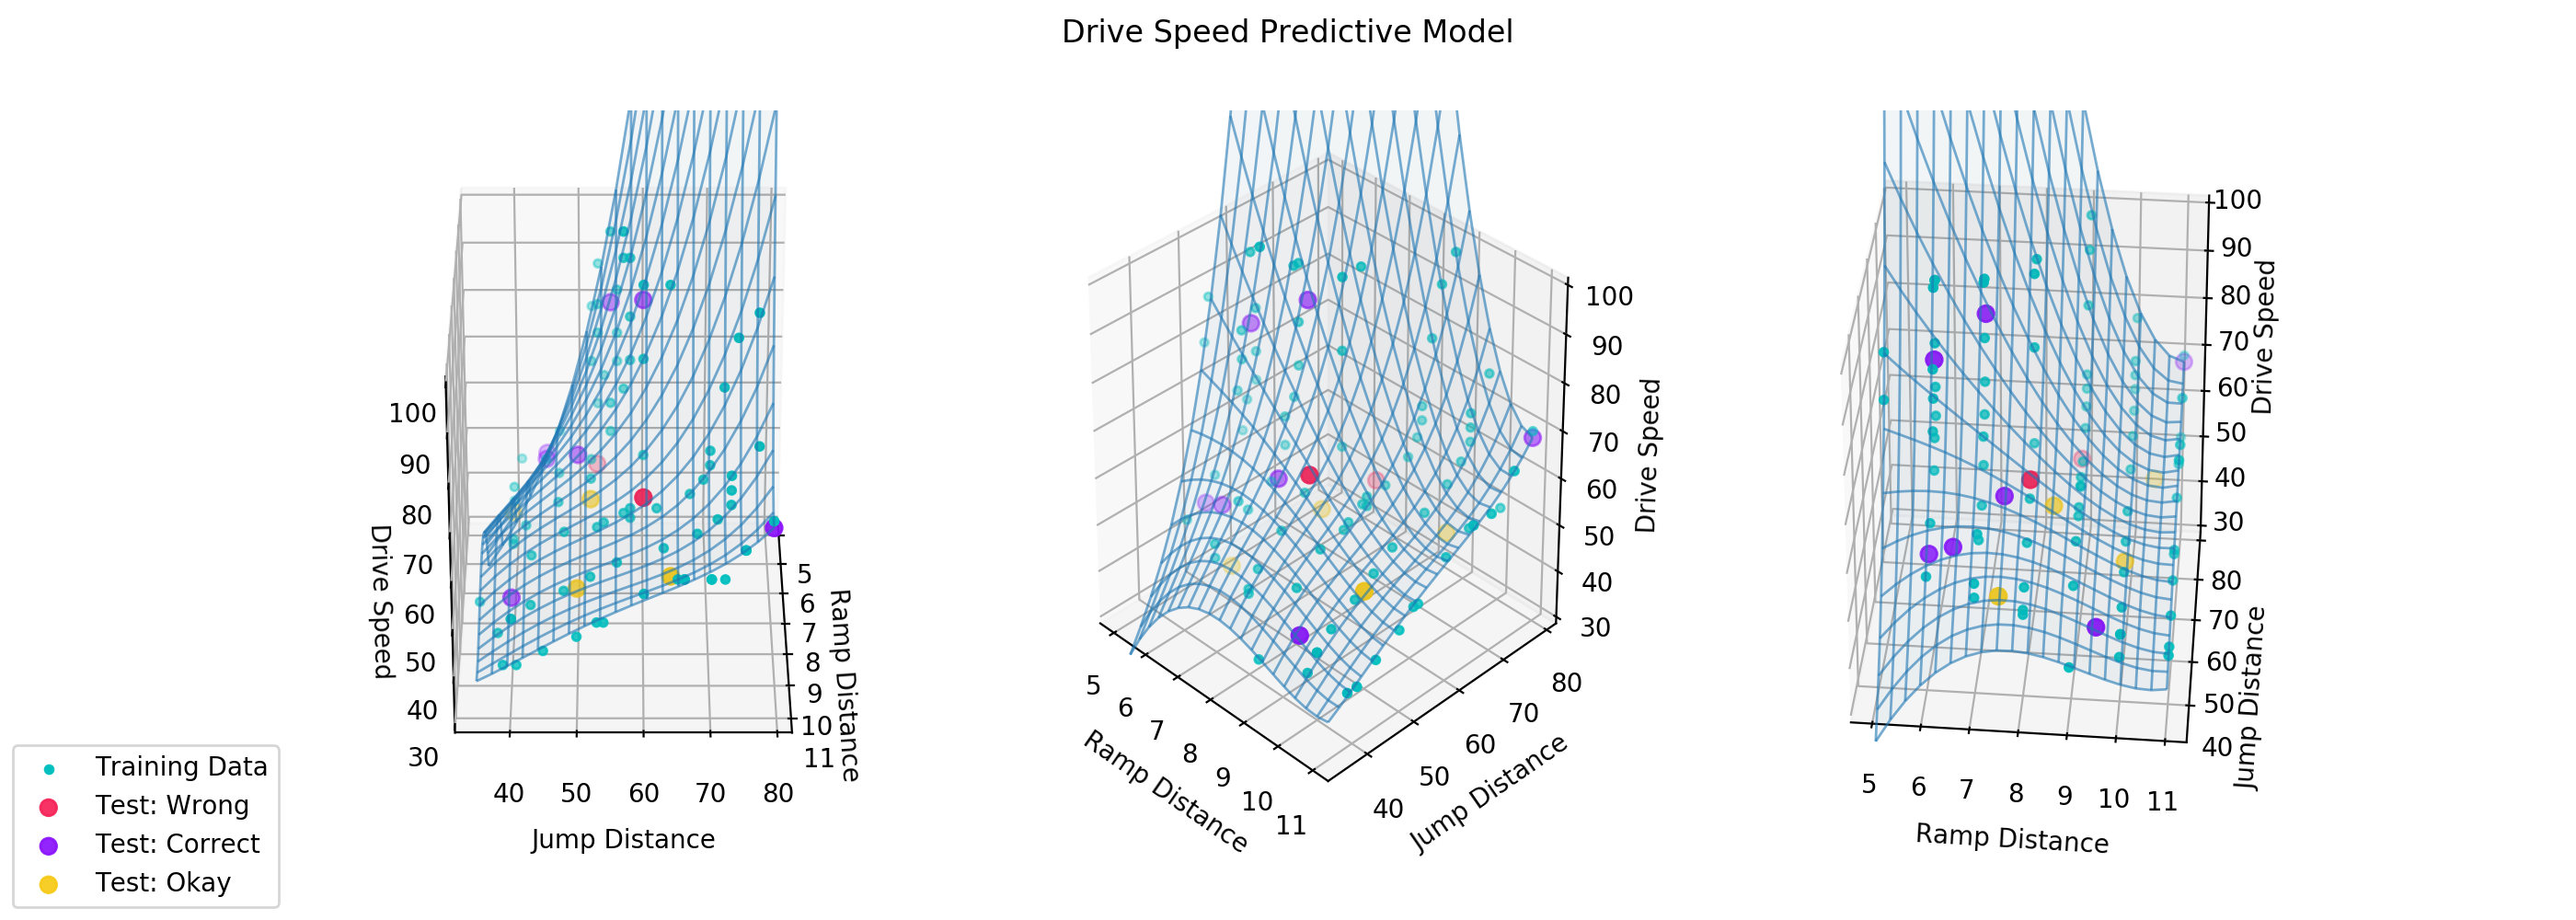

In [217]:
%matplotlib notebook
# create maps for the colors and labels of test data
cmap = ['#f62459EE', '#8c14fcEE', '#f7ca18EE']
gmap = ['wrong', 'correct', 'okay']

# start figure
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
axs = [ax1, ax2, ax3]
plots = []
ll = 0
angles = [(30, 0), (30, -45), (30, -85)]
for ax in axs:
    # plot surface and wireframe
    ax.plot_surface(Xm, Ym, Zm, rstride=1, cstride=1, alpha=0.05)
    ax.plot_wireframe(Xm, Ym, Zm, rstride=1, cstride=1, linewidth=1, alpha=0.6)

    # plot scatter of training data
    pp = ax.scatter(X_train[:,0], X_train[:,1], y_train, c='c', s=10, label='Training data')
    if ll == 0:
        plots.append(pp)
    # group and plot the test data into wrong, correct, okay
    grouping = [[], [], []]
    for res in sorted(np.c_[X_test, y_pred, results], key=lambda x: x[3]):
        grouping[int(res[3])].append(res)
    for i, group in zip(range(len(grouping)), grouping):
        g = np.array(group)
        pp2 = ax.scatter(g[:,0], g[:, 1], g[:, 2],
                   c=[cmap[int(c)] for c in g[:, 3]], s=40, label='Test Data - {}'.format(gmap[i]))
        if ll == 0:
            plots.append(pp2)
    # plot settings
    ax.set_xlabel('Ramp Distance')
    ax.set_ylabel('Jump Distance')
    ax.set_zlabel('Drive Speed')
    ax.axis('equal')
    ax.axis('tight')
    ax.set_zlim(30, 100)
    ax.view_init(angles[ll][0], angles[ll][1])
    ll += 1
fig.suptitle('Drive Speed Predictive Model')
fig.legend(tuple(p for p in plots), ('Training Data', 'Test: Wrong', 'Test: Correct', 'Test: Okay'), loc=3)
plt.savefig(join(fig_dir, 'PredictiveModel.png'))
plt.show()